In [1]:
# if connecting from same gdrive, mounting it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# if connecting from different gdrive than the account running the notebook
# !sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !sudo apt-get update -qq 2>&1 > /dev/null
# !sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
# !google-drive-ocamlfuse

# if error is recieved, click on the link and authenticate

In [ ]:
# # only run if connecting from different gdrive 
# !sudo apt-get install -qq w3m # to act as web browser 
# !xdg-settings set default-web-browser w3m.desktop # to set default browser
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 128298 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
! pip install wandb

In [3]:
import wandb
wandb.login()
#ec0fa02abb6680e2e41f9e94ffb3c3a636ca9007

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy
from tqdm import tqdm

import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator 

In [30]:
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes/'
width=256
height=256
depth=3
batch_size = 64
num_classes =23

In [31]:
train_config = {"EPOCHS" : 15,
"INIT_LR" : 1e-3,
"BS" : 32,
"default_image_size" : tuple((256, 256)),
"image_size" : 0,
"directory_root" : '/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes/',
"width":256,
"height":256,
"depth":3,
"batch_size" : 64,
"num_classes" :23}

In [10]:
run = wandb.init(project="shuffleNet3", config=train_config)

wandb: Currently logged in as: prvns1997 (p1). Use `wandb login --relogin` to force relogin


In [11]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:
train_data_path = '/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes/train/'
train_dataset = datasets.ImageFolder(
    train_data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [13]:
valid_data_path = '/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes/valid/'
valid_dataset = datasets.ImageFolder(
    valid_data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [ ]:
# random_seed = 33
# random.seed(random_seed)
# torch.manual_seed(random_seed)

# dataset = {}

# train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.3, random_state=random_seed)
# dataset['train'] = Subset(leaf_datasets, train_idx)
# valtest          = Subset(leaf_datasets, valtest_idx)


# val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.7, random_state=random_seed)
# dataset['valid'] = Subset(valtest, val_idx)
# dataset['test']  = Subset(valtest, test_idx)

In [14]:
print(len(train_dataset))
print(len(valid_dataset))

42347
10586


In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(train_dataset,
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(valid_dataset,
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
# dataloaders['test'] = DataLoader(dataset['test'],
#                                   batch_size=batch_size, shuffle=False,
#                                   num_workers=8)


batch_num['train'], batch_num['valid'] = len(dataloaders['train']), len(dataloaders['valid'])
print('batch_size : %d,  train/valid : %d / %d' % (batch_size, batch_num['train'], batch_num['valid']))

batch_size : 64,  train/valid : 662 / 166


In [19]:
#class distribution test

count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)

v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fae6e2c34c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


IndexError: ignored

In [ ]:
# imgtest = None
# for images, labels in dataloaders['train']:  
#     print(images)
#     print(labels)
#     imgtest = images[3]
#     print(imgtest.shape)
#     break

# imgtest = imgtest.numpy()
# imgtest = np.moveaxis(imgtest, 0, -1)
# imshow(imgtest)

In [20]:
# modeling
from torchvision import models
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.shufflenet_v2_x2_0(weights = None,num_classes=num_classes,progress=True)
        
        for parameter in self.model.parameters():
            parameter.require_grad = False
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [ ]:
dataloaders['train'] = DeviceDataLoader(dataloaders['train'], device)
dataloaders['valid'] = DeviceDataLoader(dataloaders['valid'], device)
# dataloaders['test'] = DeviceDataLoader(dataloaders['test'], device)

In [21]:
model = to_device(PlantDiseaseModel(classes=num_classes), device) 

optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()
model


PlantDiseaseModel(
  (model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

In [ ]:
# # defining the model and moving it to the GPU
# model = to_device(PlantDiseaseModel(len(train.classes)), device) 
# model

In [22]:
device


device(type='cuda')

In [32]:
num_epochs = 15
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0
dev = device
since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in tqdm(enumerate(dataloaders['train'])):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in tqdm(enumerate(dataloaders['valid'])):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    wandb.log({'epoch':(epoch+1)/num_epochs,'training_loss': trn_loss/batch_num['train'],'validation_loss': val_loss/batch_num['valid']})
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet3/best_model.pt')
print("model saved")

662it [00:41, 15.83it/s]
166it [00:09, 17.49it/s]


epoch: 1/15 | trn loss: 2.9610 | val loss: 2.9506 | 0m 52s elapsed
best model updated-epoch: 1 | val_accuracy: 70.8334


662it [00:41, 15.80it/s]
166it [00:09, 17.06it/s]


epoch: 2/15 | trn loss: 2.9450 | val loss: 2.9340 | 1m 44s elapsed
best model updated-epoch: 2 | val_accuracy: 74.3908


662it [00:42, 15.76it/s]
166it [00:09, 17.38it/s]

epoch: 3/15 | trn loss: 2.9232 | val loss: 2.9075 | 2m 36s elapsed
best model updated-epoch: 3 | val_accuracy: 83.4658



662it [00:42, 15.74it/s]
166it [00:09, 17.09it/s]


epoch: 4/15 | trn loss: 2.8984 | val loss: 2.8819 | 3m 28s elapsed
best model updated-epoch: 4 | val_accuracy: 87.4104


662it [00:42, 15.76it/s]
166it [00:09, 17.35it/s]


epoch: 5/15 | trn loss: 2.8793 | val loss: 2.8685 | 4m 20s elapsed
best model updated-epoch: 5 | val_accuracy: 88.3784


662it [00:42, 15.67it/s]
166it [00:09, 17.11it/s]


epoch: 6/15 | trn loss: 2.8665 | val loss: 2.8607 | 5m 13s elapsed
best model updated-epoch: 6 | val_accuracy: 89.3948


662it [00:42, 15.61it/s]
166it [00:09, 17.10it/s]

epoch: 7/15 | trn loss: 2.8592 | val loss: 2.8555 | 6m 5s elapsed
best model updated-epoch: 7 | val_accuracy: 89.9272



662it [00:42, 15.67it/s]
166it [00:09, 17.38it/s]


epoch: 8/15 | trn loss: 2.8532 | val loss: 2.8493 | 6m 58s elapsed
best model updated-epoch: 8 | val_accuracy: 90.2660


662it [00:42, 15.66it/s]
166it [00:09, 16.98it/s]

epoch: 9/15 | trn loss: 2.8457 | val loss: 2.8409 | 7m 50s elapsed
best model updated-epoch: 9 | val_accuracy: 91.9600



662it [00:42, 15.72it/s]
166it [00:09, 17.11it/s]

epoch: 10/15 | trn loss: 2.8361 | val loss: 2.8308 | 8m 42s elapsed
best model updated-epoch: 10 | val_accuracy: 100.7688



662it [00:42, 15.63it/s]
166it [00:09, 16.91it/s]


epoch: 11/15 | trn loss: 2.8235 | val loss: 2.8170 | 9m 35s elapsed
best model updated-epoch: 11 | val_accuracy: 104.5440


662it [00:42, 15.61it/s]
166it [00:09, 16.90it/s]

epoch: 12/15 | trn loss: 2.8100 | val loss: 2.8028 | 10m 28s elapsed
best model updated-epoch: 12 | val_accuracy: 106.7704



662it [00:42, 15.62it/s]
166it [00:09, 17.22it/s]


epoch: 13/15 | trn loss: 2.7980 | val loss: 2.7943 | 11m 20s elapsed
best model updated-epoch: 13 | val_accuracy: 108.2708


662it [00:42, 15.56it/s]
166it [00:09, 16.71it/s]

epoch: 14/15 | trn loss: 2.7881 | val loss: 2.7865 | 12m 13s elapsed



662it [00:43, 15.39it/s]
166it [00:09, 16.80it/s]


epoch: 15/15 | trn loss: 2.7779 | val loss: 2.7710 | 13m 7s elapsed
best model updated-epoch: 15 | val_accuracy: 115.8212
Training complete in 13m 7s
Best valid Acc: 115.8
model saved


In [24]:
!pwd

/content


In [25]:
model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet3/best_model.pt')
print("model saved")

model saved


In [33]:
print(trn_loss_list)

[2.9610122888830133, 2.945037191007793, 2.9232319269295544, 2.898442360929852, 2.8792704109698986, 2.8665178830529987, 2.859220574269482, 2.853185741202709, 2.8456615105136285, 2.8361076703604615, 2.823512563532573, 2.8100282879394345, 2.7979947735535773, 2.788122369443542, 2.7778599424304558]


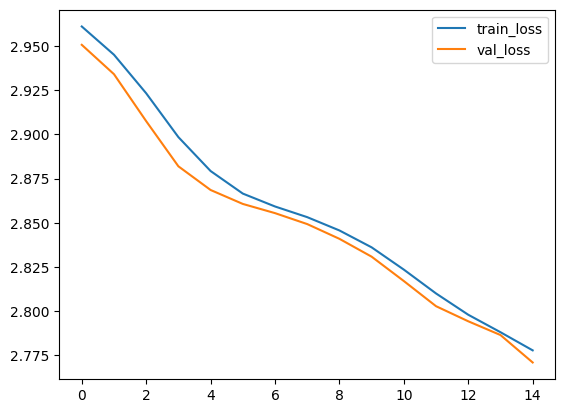

In [34]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

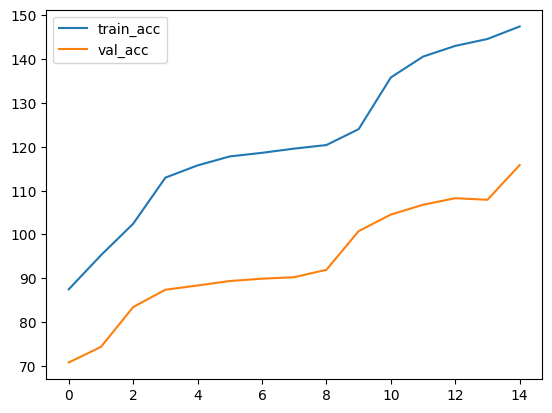

In [38]:
trn_acc_list = [t.to('cpu') for t in trn_acc_list]
val_acc_list = [t.to('cpu') for t in val_acc_list]
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [ ]:
# best_model = PlantDiseaseModel()
# best_model.load_state_dict(torch.load('best_model.pt'))


In [ ]:
%pwd

In [ ]:
corrects = 0
total = 0
best_model = PlantDiseaseModel(classes =23)
best_model.load_state_dict(torch.load('ShuffleNet3/best_model.pt'))
best_model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model = best_model.to(device)
# Set the model to evaluation mode
best_model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in dataloaders['test']:
    images, labels = images.to(device), labels.to(device)
    # Predict the labels
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))
print('Confusion matrix:\n', conf_matrix)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
